In [1]:
import dataset_loader
import matplotlib.pyplot as plt
import midi
import numpy as np
import similarity
import util

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"

SLICE_DURATION = 5 # sec
EXPANSION_RATE = 1.5
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 1
SETTLING_FRAME = 8
COMPENSATION_FRAME = 0

In [3]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                           slice_duration=SLICE_DURATION,
                           expansion_rate=EXPANSION_RATE,
                           frame_per_second=FRAME_PER_SECOND,
                           shuffle=True)

In [4]:
# for i in range(100):
#     print("=============================================================")
#     score, perf, (head, tail) = gen.__next__()
#     plot_midi_matrix(score, "score")
#     plot_midi_matrix(perf, "perf", head, tail)

#     score_ = process_midi_matrix(score, SETTLING_FRAME).T
#     plot_midi_matrix(score_, "score")
#     perf_ = process_midi_matrix(perf, SETTLING_FRAME).T
#     plot_midi_matrix(perf_, "perf", head, tail)

In [5]:
score, perf, (original_head, original_tail) = next(gen)

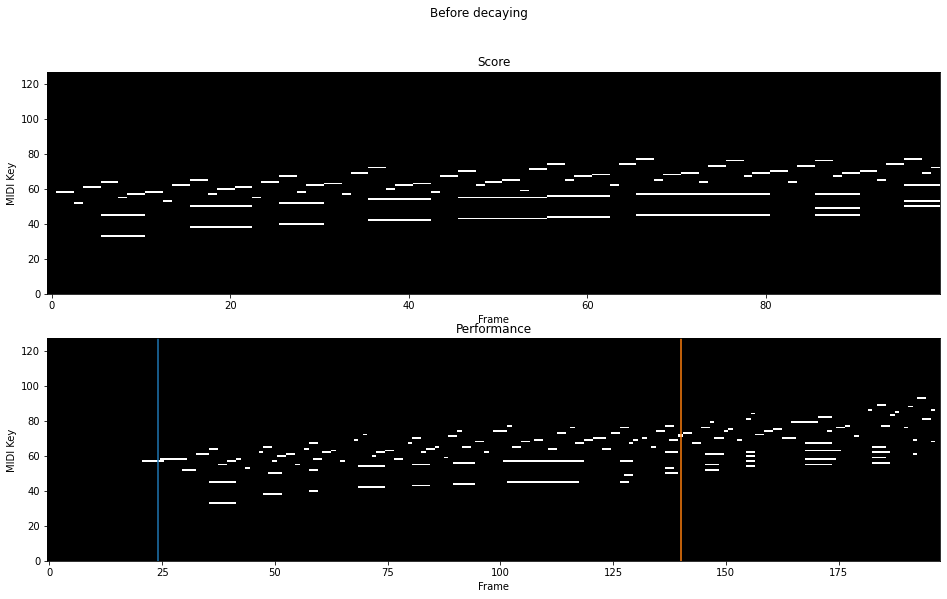

<Figure size 432x288 with 0 Axes>

In [6]:
util.plot_midi_matrices(score, perf, original_head, original_tail, "Before decaying")

In [7]:
processed_score = util.process_decay_to_midi_matrix(score, SETTLING_FRAME)
processed_perf = util.process_decay_to_midi_matrix(perf, SETTLING_FRAME)

In [8]:
score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score,SETTLING_FRAME)
perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, SETTLING_FRAME)
score_sequence = score_unit_seq_list.to_representative_unit_sequence()
perf_sequence = perf_unit_seq_list.to_representative_unit_sequence()

In [9]:
cost, (predicted_head, predicted_tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_dtw(
    score_sequence, perf_sequence
)

In [10]:
original_subsequence_len = original_tail - original_head
predicted_subsequence_len = predicted_tail - predicted_head

length_accuracy = predicted_subsequence_len / original_subsequence_len
print(f"Length accuracy: {length_accuracy: .2f}")

Length accuracy:  0.97


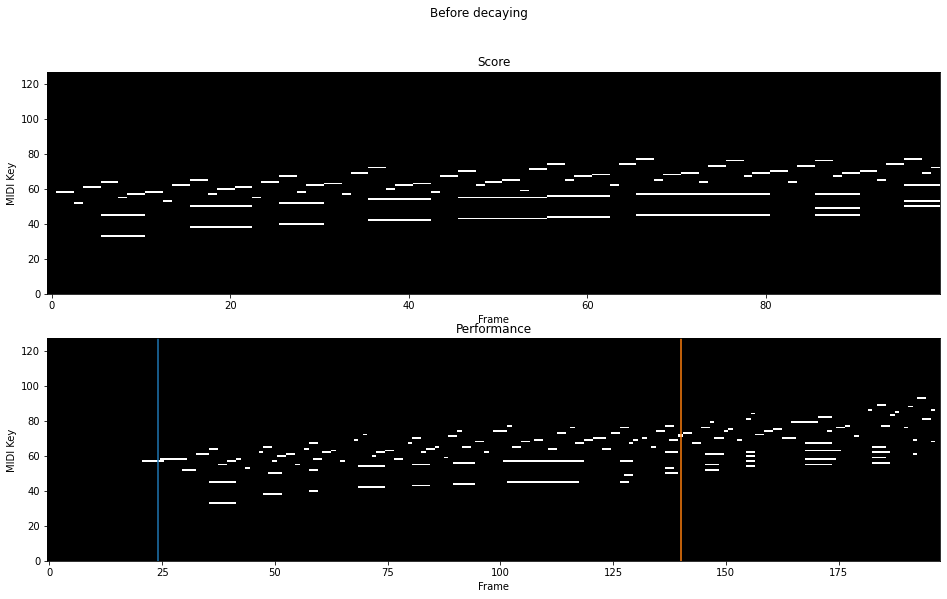

<Figure size 432x288 with 0 Axes>

In [11]:
util.plot_midi_matrices(score, perf, original_head, original_tail, "Before decaying")

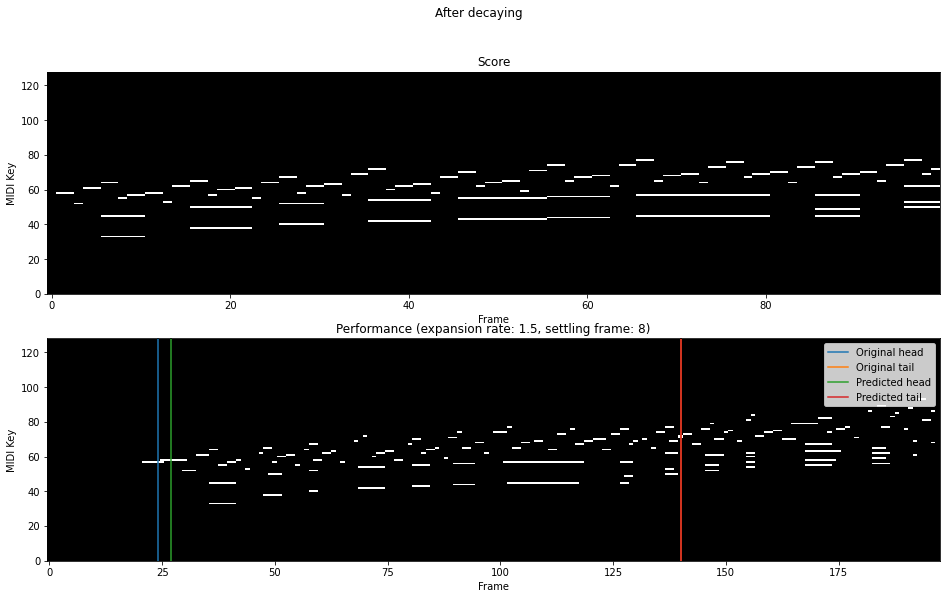

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(16, 9))
plt.suptitle("After decaying")
plt.subplot(2, 1, 1)
plt.title("Score")
plt.imshow(score, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.ylim(0, 128)
plt.subplot(2, 1, 2)
plt.title(f"Performance (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.imshow(perf, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.plot([original_head, original_head], [0, 128], label="Original head")
plt.plot([original_tail, original_tail], [0, 128], label="Original tail")
plt.plot([predicted_head, predicted_head], [0, 128], label="Predicted head")
plt.plot([predicted_tail, predicted_tail], [0, 128], label="Predicted tail")
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.ylim(0, 128)
plt.legend()
plt.show()
plt.clf()

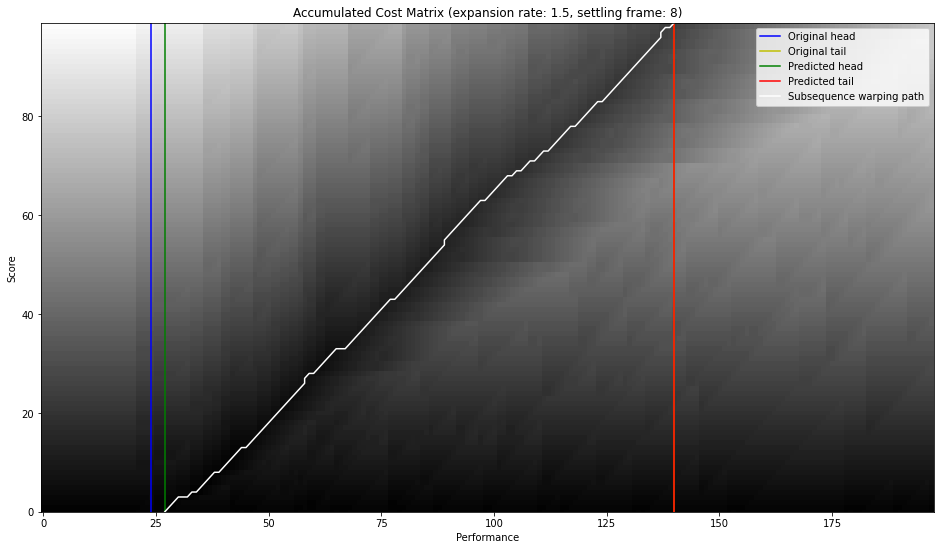

<Figure size 432x288 with 0 Axes>

In [13]:
ylim = [0, score.shape[-1] -1]
warping_path_ = np.array([(i, j) for (i, j) in warping_path])

plt.figure(figsize=(16, 9))
plt.title(f"Accumulated Cost Matrix (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.imshow(accumulated_cost_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.plot([original_head, original_head], ylim, "b", label="Original head")
plt.plot([original_tail, original_tail], ylim, "y", label="Original tail")
plt.plot([predicted_head, predicted_head], ylim, "g", label="Predicted head")
plt.plot([predicted_tail, predicted_tail], ylim, "r", label="Predicted tail")
plt.plot(warping_path_[:, 1], warping_path_[:, 0], 'w', label="Subsequence warping path")
plt.ylabel("Score")
plt.xlabel("Performance")
plt.ylim(ylim)
plt.legend()
plt.show()
plt.clf()

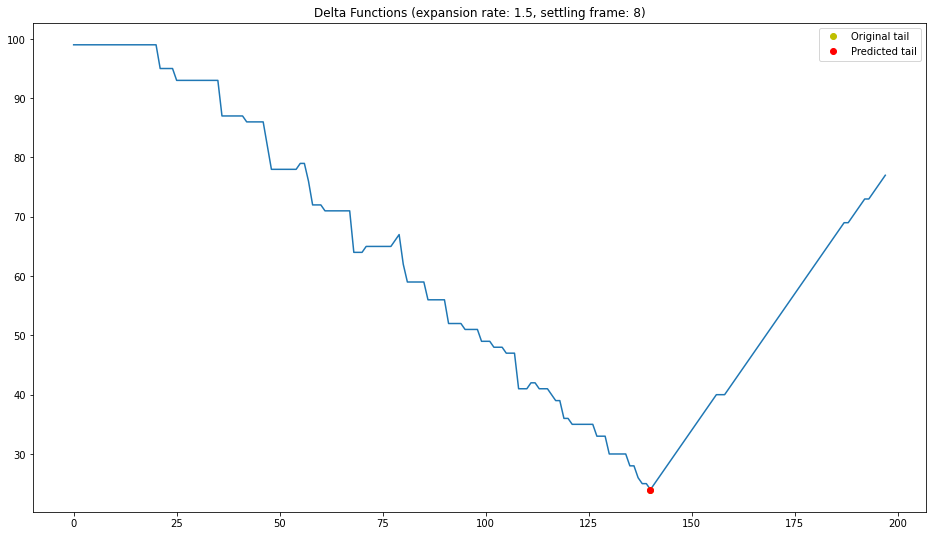

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(16, 9))
plt.title(f"Delta Functions (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.plot(np.arange(len(delta_functions)),delta_functions)
plt.plot(original_tail, delta_functions[original_tail], 'yo', label="Original tail")
plt.plot(predicted_tail, delta_functions[predicted_tail], 'ro', label="Predicted tail")
plt.legend()
plt.show()
plt.clf()

In [15]:
decayed_pitch_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
print(decayed_pitch_histogram)

[0.03404255 0.06553192 0.16340426 0.02212766 0.11574468 0.08680851
 0.04765958 0.10468085 0.06978723 0.20595744 0.06723404 0.01702128]


In [16]:
not_decayed_pitch_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
print(not_decayed_pitch_histogram)

[0.02521008 0.05462185 0.15126051 0.01680672 0.09663866 0.06722689
 0.05882353 0.12605043 0.07563026 0.2647059  0.05042017 0.01260504]
